# Automated Segmentation of Medical Images Using a Convolutional Neural Network


## Objectives
To train a Neural Network to automatically segment a selection of regions of interest (ROIs) from medical imaging data.


## Neural Network Architecture
The selected architecture is a Multiscale Pyramid 2D Convolutional Neural Network (Dourthe et al. (2021) [1]), which was chosen based on its reported ability to accurately extract contextual and morphological information from medical images at various scales.


## How to Use

### Requirements
Create a new Python 3.10 environment and install requirements.txt within this environment.
You will also need to run the following commands to install PyTorch and torchvision:
- conda install pytorch -c pytorch
- pip install torchvision

### Data Management

#### Data Structure
In order to allow the code to run successfully, it is recommended to organize the training data using the following structure:
<pre>
project_directory
└─ data
   └── train
       ├── dicoms
       │   └── contains all the raw images available in the training dataset (each scan axial slice represents a sample)
       └── labels
           └── contains all the segmentation files for the corresponding images available in the training dataset</pre>

#### Data Format
Here are the supported data formats:
- dicoms: DICOM format (.dcm)
- labels: multiple formats supported: .npy, .jpg, .png

#### Data Labelling
The images and corresponding segmentation files should have the same filenames. Otherwise the code will not be able to run successfully, as it will be looking for matching pairs of images and labels based on filenames during training.
For example, if a DICOM image is named 'slice_1.dcm', the corresponding segmentation file should be named 'slice_1.npy' or 'slice_1.jpg' or 'slice_1.png'.

#### Data Segmentation
Segmentation files can be generated using the software of choice (3D Slicer, ImageJ, Photoshop, etc.), as long as:
- The resulting files are in one of the supported formats (.npy, .jpg or .png)
- The filenames match with the corresponding segmented images
- One segmentation file is generated per slice

In addition, the pixels of the segmentation file should define what specific region of interest (ROI) each pixel belongs to. For example, if a total of 4 ROIs are being segmented, every pixel that belongs to ROI #1 should have a value of 1, every pixel that belongs to ROI #2 should have a value of 2, etc. and every pixel that is not labeled (i.e. belongs to the background or other regions) should have a value of 0.

WARNING: Make sure that the labels are consistent across samples! In other word, if the pixels of ROI #1 on image 1 have a value of 1, the pixels that belong to the same ROI on every other image in the training set should all have a value of 1.

### Notebook Setup
In the Settings section:
- Edit the different paths and filenames under the DIRECTORIES & FILENAMES section
- Choose the right input shape under the TRAINING PARAMETERS section
    - Optional: edit the save_checkpoint parameter to define how often to save the model during training
- Every other parameter can be left as their original value.

### Run the Notebook
Once the Settings have been edited, run each cell of the notebook and wait for training to be completed.


## References
[1] Dourthe B, Shaikh N, S AP, Fels S, Brown SHM, Wilson DR, Street J, Oxland TR. Automated Segmentation of spinal Muscles from Upright Open MRI Using a Multi-Scale Pyramid 2D Convolutional Neural Network. Spine (Phila Pa 1976). 2021 Dec 15. doi: 10.1097/BRS.0000000000004308. PMID: 34919072. https://pubmed.ncbi.nlm.nih.gov/34919072/

___
# Imports

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# System characteristics
import psutil
import humanize
import GPUtil as GPU
import torch.backends.cudnn as cudnn

# Computation time monitoring
from time import time

# Data visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output
from jupyterthemes import jtplot

# Data processing
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Pytoolbox import
from pytoolbox.utils import *
from pytoolbox.dataset import *
from pytoolbox.network import *
from pytoolbox.loss import *

print('Libraries successfully imported')

Libraries successfully imported


___
# System Characteristics
The cell below allows you to check whether your GPU is enabled and displays the corresponding system characteristics such as memory usage.

In [2]:
# Display local virtual memory (RAM)
print(f'\033[1mRAM Memory:\t\033[0m{humanize.naturalsize(psutil.virtual_memory().available)} (Available)\n')

# Check if GPU is enabled
print(f'\033[1mGPU enabled:\t\033[0m{torch.cuda.is_available()}\n')

# Setting device on GPU ('cuda') if available, if not, the device will be set to CPU ('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If device set to GPU ('cuda'), display device information
if device.type == 'cuda':
    # Collect GPU information
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print(f'\033[1mDevice Name:\t\033[0m{torch.cuda.get_device_name(0)}')
    print(f'\033[1mMemory Details:\t\033[0m{gpu.memoryTotal/1000:3.1f} GB '
          f'(Total)\t\t{gpu.memoryUsed/1000:3.1f} GB ({gpu.memoryUtil*100:.0f}% Used) '
          f'\t{gpu.memoryFree/1000:4.1f} GB ({100-gpu.memoryUtil*100:.0f}% Free)')

RAM Memory:	23.3 GB (Available)

GPU enabled:	True

Device Name:	NVIDIA GeForce RTX 3080 Ti Laptop GPU
Memory Details:	16.4 GB (Total)		0.1 GB (1% Used) 	16.1 GB (99% Free)


___
# Settings

In [3]:
###########################
# DIRECTORIES & FILENAMES #
###########################

# Define path towards data directory
main_dir = 'C:/Users/bdour/IDrive-Sync/Work/Academic/UBC/Spine Modeling Project/Data/Autosegmentation data/PublicRepo/data/open_MRI_ASD'

# Define paths towards training data
train_dicoms_path = main_dir + '/train/dicoms'
train_labels_path = main_dir + '/train/labels'

# Define path towards directory where the trained model and training history will be saved
model_export_path = 'trained_models'
# Check if the corresponding directory exists, if not, create it
if not os.path.exists(os.path.abspath(model_export_path)):
    os.mkdir(os.path.abspath(model_export_path))

# Define filename to save trained model state 
#   NOTE: the number of epochs will be added at the end of the model filename when saved
#   to reflect training state
model_filename = 'open_MR_autoseg_model'


#######################
# TRAINING PARAMETERS #
#######################

# Define input shape (i.e. number of pixels along x- or y-axis)
#   NOTE: Only one value is needed as input images are either squares,
#   or will be resized to squares within the data loader
input_shape = 256

# Define number of labels (i.e. number of regions to segment)
num_labels = 6

# Define number of epochs (i.e. iterations) used to complete training
epochs = 500

# Define data augmentation parameters
augment_params = {'aug_prob': 0.5,
                  'rotation': True,
                  'rot_range': 5,
                  'warping': True,
                  'warp_range': 0.8,
                  'cropping': True,
                  'crop_range': [0.5, 0.8]}

# Define computing parameters
# (i.e. how many samples are processed simultaneously and how many parallelized computers/GPUs are used)
batch_size = 5
num_workers = 0
pin_memory = False

# Define learning parameters
learning_rate = 0.0001
dropout_rate = 0.3

# Define checkpoints parameters
print_checkpoint = 10          # Defines how often a print statement will be displayed during training (in number of epochs)
save_checkpoint = 100          # Defines how often the model state will be saved (in number of epochs)


###############################
# DATA VISUALIZATION SETTINGS #
###############################

# Dark mode
dark_mode = True

# Define Jupyter theme based on dark mode
# list available themes
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
if dark_mode:
    jtplot.style(theme='chesterish')
else:
    jtplot.style(theme='grade3')

print('Settings successfully defined')

Settings successfully defined


___
# Dataset Pre-Visualization
The cell below allows you to load and display the first batch of the dataset after being passed through the data loader.

NOTE: This data loader includes data augmentation techniques that are implemented on-the-fly.

FIRST BATCH SHAPES:
	Images:	torch.Size([5, 1, 256, 256])
	Labels:	torch.Size([5, 256, 256])


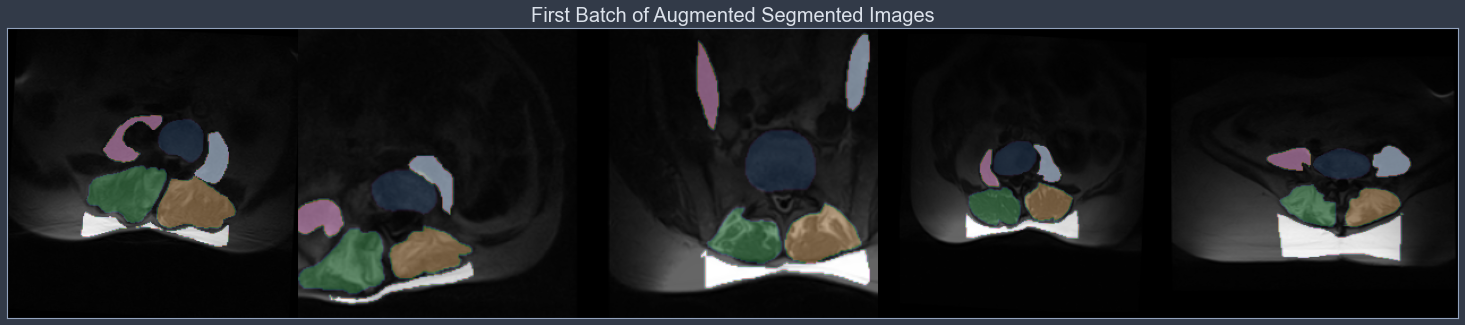

In [4]:
###################
# DATASET LOADING #
###################

# Generate dataset
train_data = ProcessedDataset(train_dicoms_path, train_labels_path, input_shape=input_shape, augment_params=augment_params)

# Load dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Grab the first sample
for img, lab in train_loader:
    break

# Print shape of the first batch
print('FIRST BATCH SHAPES:')
print(f'\tImages:\t{img.shape}')
print(f'\tLabels:\t{lab.shape}')

# Generate grids for low and high resolution images from first batch
#   Resize to 3D array and convert to numpy.ndarray 
img_arr = img.numpy()
lab_arr = lab.numpy()

#   Initialize grid arrays with a column vector of zeros
img_grid = np.zeros((img_arr.shape[3], 1))
lab_grid = np.zeros((lab_arr.shape[2], 1))
#   Isolate the indices of 5 evenly distanced labeled frames and 
for i in range(batch_size):
    # Stack each new image along the x-axis to generate a grid of 5 stacked images
    img_grid = np.hstack([img_grid, img_arr[i, 0, :, :]])
    lab_grid = np.hstack([lab_grid, lab_arr[i, :, :]])

# Display grids
plt.figure(figsize=(26, 6))
plt.imshow(img_grid, cmap='gray')
plt.imshow(lab_grid, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('First Batch of Augmented Segmented Images', fontsize=20)
plt.show()

___
# Model Training

Completed epochs:    1/500 | Dice loss: 1.774 | Mean dice score: 0.113 | Time elapsed:  0 hrs  0 mins 10 secs
Completed epochs:   10/500 | Dice loss: 1.262 | Mean dice score: 0.369 | Time elapsed:  0 hrs  0 mins 35 secs
Completed epochs:   20/500 | Dice loss: 0.982 | Mean dice score: 0.509 | Time elapsed:  0 hrs  1 mins  4 secs
Completed epochs:   30/500 | Dice loss: 1.021 | Mean dice score: 0.489 | Time elapsed:  0 hrs  1 mins 34 secs
Completed epochs:   40/500 | Dice loss: 0.728 | Mean dice score: 0.636 | Time elapsed:  0 hrs  2 mins  3 secs
Completed epochs:   50/500 | Dice loss: 0.753 | Mean dice score: 0.623 | Time elapsed:  0 hrs  2 mins 31 secs
Completed epochs:   60/500 | Dice loss: 0.712 | Mean dice score: 0.644 | Time elapsed:  0 hrs  2 mins 60 secs
Completed epochs:   70/500 | Dice loss: 0.575 | Mean dice score: 0.712 | Time elapsed:  0 hrs  3 mins 28 secs
Completed epochs:   80/500 | Dice loss: 0.664 | Mean dice score: 0.668 | Time elapsed:  0 hrs  3 mins 56 secs
Completed 

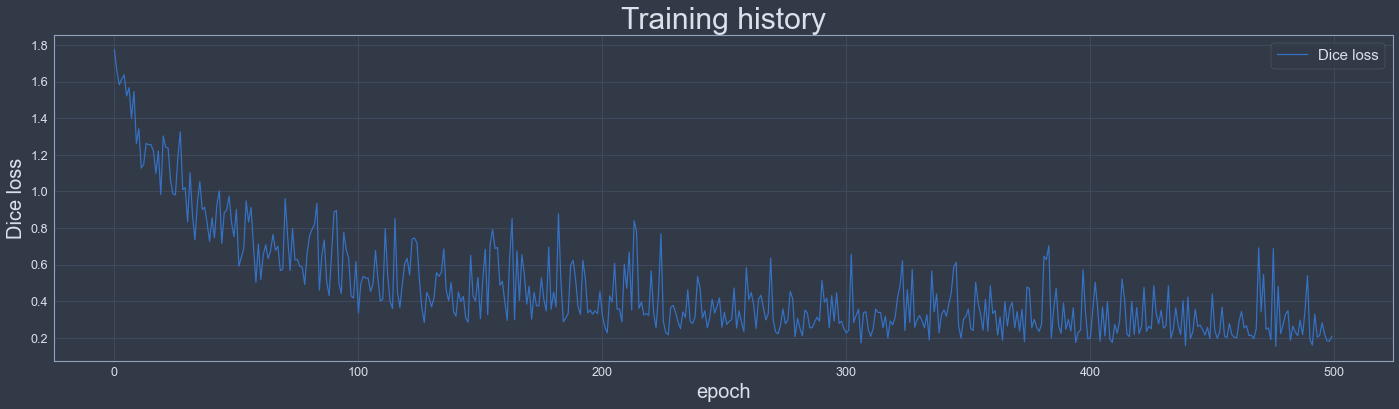


Total computing time:  0 hrs 23 mins  1 secs


In [5]:
######################
# DATASET DEFINITION #
######################

# Generate dataset
train_data = ProcessedDataset(train_dicoms_path, train_labels_path, augment_params=augment_params)

# Load dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Grab the first sample
for img, lab in train_loader:
    break
    
# Define model parameters
input_dim = img.shape[1]
input_shape = img.shape[2]

########################
# MODEL INITIALIZATION #
########################

# Create initialization function
def init(model):
    if isinstance(model, nn.Conv3d) or isinstance(model, nn.ConvTranspose3d):
        nn.init.kaiming_normal(model.weight.data, 0.25)
        nn.init.constant(model.bias.data, 0)
        
# Create instance of the multi-scale pyramid model
model = MultiScalePyramid(num_labels=num_labels, input_shape=input_shape, training=True)

# Initialize model
model.apply(init)

############################
# OPTIMIZER INITIALIZATION #
############################

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate decay
lr_decay = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)

##################
# MODEL TRAINING #
##################

# Assign device to 'cuda' if available, or to 'cpu' otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enable cudnn benchmark, which allows cudnn to look for the optimal set of algorithms for the current device configuration
cudnn.benchmark = True

# Implements data parallelism at the module level
model = torch.nn.DataParallel(model)

# Assign model to available device ('cuda' or 'cpu')
model = model.to(device)

# Generate instance of the loss function
criterion = MultiClassDiceLoss(num_labels=num_labels, input_shape=input_shape)

# Initialize mean epoch loss tracker (-> one mean loss value per epoch)
mean_epoch_loss = []

# Initialize time tracker
start_time = time()

for epoch in range(1, epochs+1):
    
    # Update learning rate decay (will only update by gamma when epoch milestone is reached)
    lr_decay.step()
    
    # Initialize mean sample loss tracker (-> one mean loss value per sample)
    mean_sample_loss = []
    
    # Loop through training samples
    for img, lab in train_loader:
        
        # Assign image to available device ('cuda' or 'cpu')
        img = img.to(device)

        # Pass sample through model
        stage1_output, stage2_output = model(img)
        
        # Calculate sample loss
        loss = criterion(stage1_output, stage2_output, lab, device)
        
        # Append loss to mean sample loss tracker
        mean_sample_loss.append(loss.item())
        
        # Update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append loss to mean epoch loss tracker
    mean_epoch_loss.append(loss.item())    
    
    # Print update statement for tracking
    if epoch == 1 or epoch%print_checkpoint == 0:
        current_time = time() - start_time
        print(f'\033[1mCompleted epochs:\033[0m {epoch:4.0f}/{epochs} | '
              f'\033[1mDice loss:\033[0m {loss.item():4.3f} | '
              f'\033[1mMean dice score:\033[0m {(2-loss.item())/2:4.3f} | '
              f'\033[1mTime elapsed:\033[0m {current_time//3600:2.0f} hrs '
              f'{(current_time - current_time//3600*3600)//60:2.0f} mins '
              f'{current_time%60:2.0f} secs')

    # Save model every checkpoint
    if epoch%save_checkpoint == 0:
        #   Define current model state using dictionary
        model_state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save model checkpoint
        torch.save(model_state, model_export_path + '/' + model_filename + '_' + str(model_state['epoch']) + '.pt')
        #   Print save statement
        print(f'\n\tCheckpoint -> Model saved at {epoch:4.0f}/{epochs} epochs\n')

# Define final model state using dictionary
model_state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

# Generate final loss history DataFrame
loss_history = pd.DataFrame(mean_epoch_loss, columns=['Dice loss'])

# Save final model and loss history
torch.save(model_state, model_export_path + '/' + model_filename + '_' + str(model_state['epoch']) + '.pt')
loss_history.to_csv(model_export_path + '/' + model_filename + '_history_' + str(epoch) + '.csv')

# Plot training history
loss_history.plot(figsize=(24, 6))
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('Dice loss', fontsize=20)
plt.title('Training history', fontsize=30)
plt.show()

# Print total computing time
total_time = time() - start_time
print(f'\033[1m\nTotal computing time:\033[0m {total_time//3600:2.0f} hrs '
      f'{(total_time - total_time//3600*3600)//60:2.0f} mins '
      f'{total_time%60:2.0f} secs')

<img src='img/icord_footer.jpg' /></a>